In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

Read the dataset

In [2]:
real_df = pd.read_csv("Data set 1 (12 KB) - heart_disease.csv")
df = real_df.copy(deep=True)

# drop the duplicate rows
df = df.drop_duplicates()
print("before dropping : ", real_df.shape)
print("after dropping : ", df.shape)

before dropping :  (303, 14)
after dropping :  (302, 14)


EDA
===

### Visualizing Pearson correlation

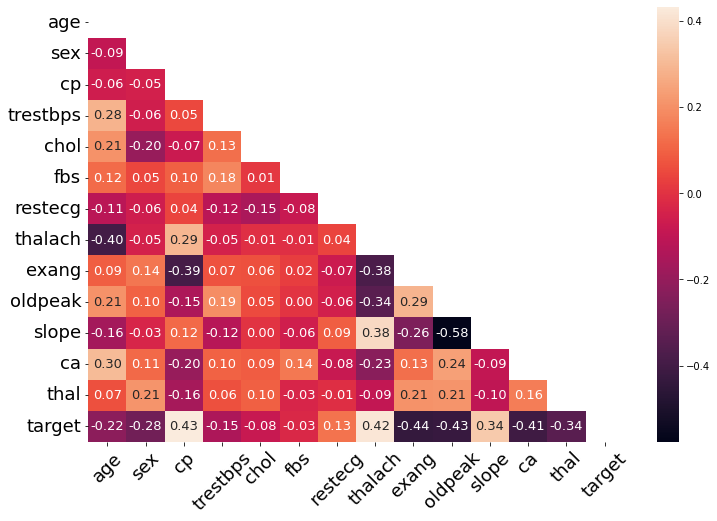

In [3]:
plt.figure(figsize=(12, 8))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
masked_corr = corr.mask(mask)
sns.heatmap(masked_corr, annot=True, annot_kws={"size": 13}, fmt='.2f') 

plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)

plt.show()

### Visualizing Heart Disease Presence

<Figure size 720x432 with 0 Axes>

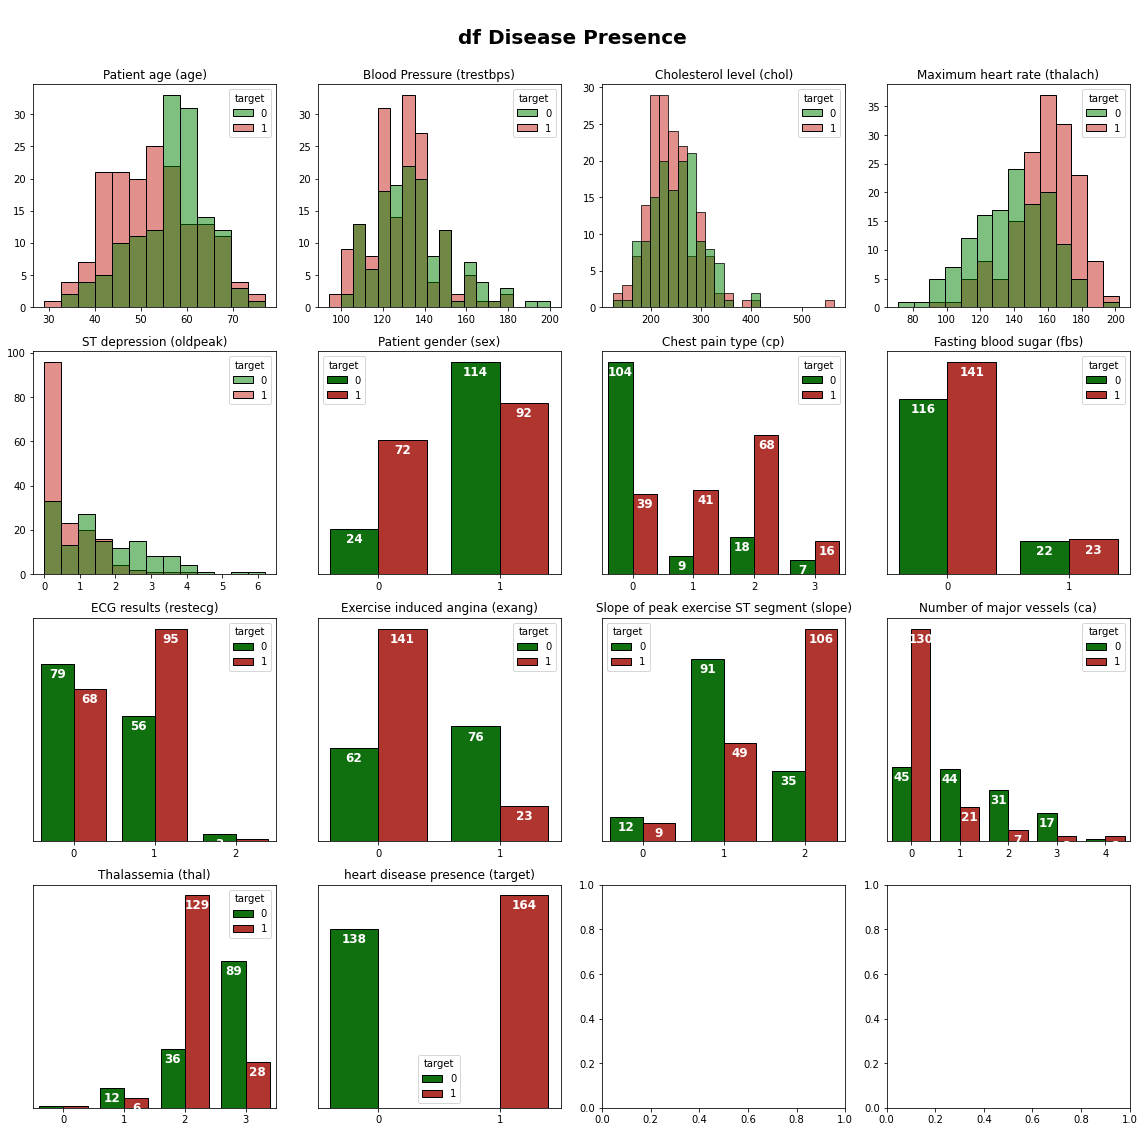

In [4]:

# Add a legend for the entire subplot
plt.figure(figsize=(10, 6))

# Define the columns to analyze
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Define the column descriptions
descriptions = {
    'age': 'Patient age (age)',
    'trestbps': 'Blood Pressure (trestbps)',
    'chol': 'Cholesterol level (chol)',
    'thalach': 'Maximum heart rate (thalach)',
    'oldpeak': 'ST depression (oldpeak)',
    'sex': 'Patient gender (sex)',
    'cp': 'Chest pain type (cp)',
          'fbs': 'Fasting blood sugar (fbs)',
          'restecg': 'ECG results (restecg)',
          'exang': 'Exercise induced angina (exang)',
          'slope': 'Slope of peak exercise ST segment (slope)',
          'ca': 'Number of major vessels (ca)',
          'thal': 'Thalassemia (thal)',
          'target': 'heart disease presence (target)'
}

# Create a figure with subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('\ndf Disease Presence\n', fontsize=20, fontweight='bold')

# Define the color palette
palette = {0: 'green', 1: '#C52219'}

# Loop through the columns and plot the charts
for i, cols in enumerate(descriptions.keys()):
    # Get the row and column index of the subplot
    row = i // 4
    col = i % 4

    # Check if the column should use histplot or barplot
    if cols in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        # Plot the histplot with seaborn
        sns.histplot(data=df, x=cols, hue="target", ax=axes[row][col], palette=palette)
    else:
        # Plot the countplot with seaborn
        sns.countplot(data=df, x=cols, hue="target", ax=axes[row][col], palette=palette, linewidth=1, edgecolor='black')
        
        # Turn off the y-axis
        axes[row][col].get_yaxis().set_visible(False)

        # Add annotations to the countplot
        for p in axes[row][col].patches:
            axes[row][col].annotate(format(p.get_height(), '.0f'),
                                    (p.get_x() + p.get_width() / 2., p.get_height()),
                                    ha='center', va='center',
                                    xytext=(0, -10),
                                    textcoords='offset points',
                                    color='white',
                                    fontsize=12,
                                    fontweight='bold')

    # Set the title and labels
    axes[row][col].set_title(descriptions[cols])
    axes[row][col].set_xlabel("")
    axes[row][col].set_ylabel("")

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

# Remove outliers in the dataset

In [5]:
def detect_outliers(data):
    outliers = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

z_outliers = []
for columns in df.columns:
    # check if the column has outliers 
    if(detect_outliers(df[columns]) != [] and detect_outliers(df[columns]) != [0, 0]):
        # store the columns with outliers and the outliers values
        z_outliers.append((columns, detect_outliers(df[columns])))

print("Before removing outliers: ", df.shape)
for feature, outliers_list in z_outliers:
    df = df[~df[feature].isin(outliers_list)]

print("After removing outliers: ", df.shape)

Before removing outliers:  (302, 14)
After removing outliers:  (289, 14)


# Feature selection using Pearson correlation
Result :
* `more_important_features`
* `less_important_features`

In [6]:
# more important features
correlationranking = df.corr().abs()['target'].sort_values(ascending=False)
more_important_features = correlationranking[correlationranking>0.2].drop('target')
more_important_features = more_important_features.index.tolist()

# less important features
less_important_features = correlationranking[correlationranking < 0.2]
less_important_features = less_important_features.index.tolist()

## Feature selection using sklearn
Result :
* `feature_selection`

In [7]:
# feature selection with sklearn
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

collected_features = []

# function to get the features
def getFeatures(selector):
    # Fit the selector on the data
    selector.fit(X,y)

    # Get the list of features based on column index
    selected_features = X.columns[selector.get_support(indices=True)].tolist()
    
    collected_features.extend(selected_features)

# 1) Univariate feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Pick only 5 features with highest f_classif score
selector = SelectKBest(f_classif, k=5)

getFeatures(selector)

# 2) Recursive feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create the RFE with a LogisticRegression estimator and 5 features to select
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=5, step=1)

getFeatures(selector)

# 3) Tree-based feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

# Create and fit the ExtraTreesClassifier with feature selection
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=100, random_state=65), max_features=5)

getFeatures(selector)

# 4) L1-based (lasso) feature selection
# do feature selection using L1-based feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# pick the top 5 features
selector = SelectFromModel(LinearSVC(penalty='l1', dual=False), max_features=5)

getFeatures(selector)

# count and sort the features by their occurence
feature_counts = pd.Series(collected_features).value_counts()

* ### Conclude all feature selection methods by counting the number of times a feature was selected

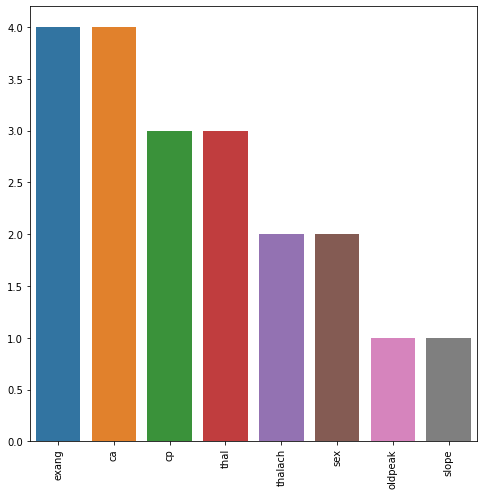

In [8]:
# count and sort the features by their occurence
feature_counts = pd.Series(collected_features).value_counts()

# Plot the result
plt.figure(figsize=(8,8))
sns.barplot(x=feature_counts.index, y=feature_counts.values)
plt.xticks(rotation=90)
plt.show()


In [9]:
feature_selection = [("all features in dataset", sorted(df.columns[:13].tolist())),
                     ("more_important_features", sorted(more_important_features)),
                     ("less_important_features", sorted(less_important_features)),
                     ("all_sklearn_features", sorted(feature_counts.index.tolist())),
                     ("top5_sklearn_features", sorted(feature_counts.index.tolist()[:5]))]

for x,y in feature_selection:
    print(x, " : ", y)

all features in dataset  :  ['age', 'ca', 'chol', 'cp', 'exang', 'fbs', 'oldpeak', 'restecg', 'sex', 'slope', 'thal', 'thalach', 'trestbps']
more_important_features  :  ['age', 'ca', 'cp', 'exang', 'oldpeak', 'sex', 'slope', 'thal', 'thalach']
less_important_features  :  ['chol', 'fbs', 'restecg', 'trestbps']
all_sklearn_features  :  ['ca', 'cp', 'exang', 'oldpeak', 'sex', 'slope', 'thal', 'thalach']
top5_sklearn_features  :  ['ca', 'cp', 'exang', 'thal', 'thalach']


### Exhaustive Feature Selection (using all possible combinations of features)

In [10]:
from itertools import combinations

def generate_combinations(df):
    features = df.columns[:13]  # Select the first 13 columns as features
    all_combinations = [
        (', '.join(sorted(combination)), sorted(combination)) 
        for r in range(1, len(features) + 1) 
        for combination in combinations(features, r)
    ]
    
    return all_combinations

features = generate_combinations(df)
len(features)

8191

## Create function to split and transform data

In [27]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_test_data(df, features):
    X = df[features]

    y = df['target']

    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # scale the data using standard scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

## Create function to train and evaluate the 3 models

In [12]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

def training_models(X_train, X_test, y_train, y_test):
    models = [
        ("KNN", KNeighborsClassifier()),
        ("Naive Bayes Bernoulli", BernoulliNB()),
        ("SVM", SVC())
    ]

    results = []

    # loop through each model and fit, predict, and score
    for name, model in models:
        print(f"Now training {name} model")

        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)

        results.append({"model": name, "accuracy": accuracy})

    return pd.DataFrame(results)

## Evaluate the accuracy score of the all features combination in Exhaustive Feature Selection

In [13]:
combination_accuracy = pd.DataFrame()

print("remove by zscore")
for desc, cols in features:
    print(f"\ntraining models for features : {desc}")
    training_summary = training_models(*train_test_data(df, cols))
    training_summary['features'] = desc
    combination_accuracy = combination_accuracy.append(training_summary)    

remove by zscore

training models for features : age
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features : sex
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features : cp
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features : trestbps
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features : chol
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features : fbs
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features : restecg
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features : thalach
Now training KNN model
Now training Naive Bayes Bernoulli model
Now train

## Evaluate how well these features fare among all the features in Exhuaustive Feature Selection 
* `all features in dataset`
* `more_important_features`
* `less_important_features`
* `all_sklearn_features`
* `top5_sklearn_features`

In [14]:
combination_accuracy = combination_accuracy.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

matching = pd.DataFrame()

for desc, columns in feature_selection:
    print("Now matching for features : ", desc)
    match = ', '.join(columns)
    # Filter the combination accuracy dataframe by the match and assign the description column
    match_df = combination_accuracy[combination_accuracy['features'] == match].assign(description=desc)
    # Append the match dataframe to the matching dataframe
    matching = matching.append(match_df)
    
# replace accuracy column with the max accuracy for each description
grouped = matching.groupby('description')['accuracy'].transform(max)

# Filter the DataFrame to include only the rows with the highest accuracy for each description
max_accuracy_rows = matching[matching['accuracy'] == grouped]
max_accuracy_rows.sort_values(by='accuracy', ascending=False, inplace=True)
max_accuracy_rows

Now matching for features :  all features in dataset
Now matching for features :  more_important_features
Now matching for features :  less_important_features
Now matching for features :  all_sklearn_features
Now matching for features :  top5_sklearn_features


,model,accuracy,features,description
47,SVM,0.931034,"age, ca, chol, cp, exang, fbs, oldpeak, restec...",all features in dataset
184,SVM,0.931034,"ca, cp, exang, oldpeak, sex, slope, thal, thalach",all_sklearn_features
3343,Naive Bayes Bernoulli,0.879310,"age, ca, cp, exang, oldpeak, sex, slope, thal,...",more_important_features
3356,SVM,0.879310,"age, ca, cp, exang, oldpeak, sex, slope, thal,...",more_important_features
2086,SVM,0.879310,"ca, cp, exang, thal, thalach",top5_sklearn_features
24389,Naive Bayes Bernoulli,0.637931,"chol, fbs, restecg, trestbps",less_important_features


## The top 5 best features in Exhaustive Feature Selection

In [15]:
combination_accuracy.head(10)

,model,accuracy,features
0,SVM,0.965517,"ca, chol, cp, exang, oldpeak, restecg, sex, sl..."
1,SVM,0.965517,"ca, chol, cp, oldpeak, restecg, sex, slope, th..."
2,SVM,0.948276,"ca, cp, exang, oldpeak, restecg, sex, slope, t..."
3,SVM,0.948276,"age, ca, cp, oldpeak, restecg, slope, thal"
4,Naive Bayes Bernoulli,0.948276,"ca, cp, exang, fbs, oldpeak, restecg, sex, slope"
5,SVM,0.948276,"age, ca, cp, restecg, slope, thal"
6,SVM,0.948276,"ca, chol, cp, oldpeak, restecg, slope, thal"
7,SVM,0.948276,"age, ca, cp, oldpeak, restecg, sex, slope, thal"
8,SVM,0.948276,"cp, exang, fbs, oldpeak, restecg, sex, thalach..."
9,KNN,0.948276,"age, ca, cp, fbs, oldpeak, slope, thal"


## Store the top 4 features in Exhaustive Feature Selection into `best_features` 

In [39]:
best_features = combination_accuracy['features'].head(1)
best_features = best_features.str.split(', ')
best_features = best_features[0]
print(best_features)

['ca', 'chol', 'cp', 'exang', 'oldpeak', 'restecg', 'sex', 'slope', 'thal', 'trestbps']


# Optimization

## Create function to perform optimization using GridSearchCV based on features and other parameters

In [17]:
import timeit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score

df_Tuned = pd.DataFrame(columns=[['best accuracy', 'best_params', 'precision', 'recall', 'confusion matrix', 'training time']])

def grid_search_model(ranking, features, name, model, param_grid, X_train, X_test, y_train, y_test):
    
    print(f"\nNow training {name} model")

    model.fit(X_train, y_train)

    print(f"Now tuning {name} model")

    '''start time of the grid search'''
    startTimer = timeit.default_timer()

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)

    # fit the model on the scaled training data
    grid_search.fit(X_train, y_train)

    '''stop time of the grid search'''
    stopTimer = timeit.default_timer()
    
    best_model = grid_search.best_estimator_
    
    # predict on the test data using the best estimator found by GridSearchCV
    y_pred = best_model.predict(X_test)

    results = []
    results.append({
        "model": name,
        "features": features,
        "features ranking": ranking,
        "base accuracy" : model.score(X_test, y_test),
        "best_accuracy": best_model.score(X_test, y_test),
        "best_params": str(best_model),
        "precision": round(precision_score(y_test, y_pred), 6),
        "recall": round(recall_score(y_test, y_pred), 6),
        "confusion_matrix": str(confusion_matrix(y_test, y_pred)).replace('\n', '')
    })

    return pd.DataFrame(results)

## Specify the parameters to be tuned

Maximum accuracy:  0.9482758620689655 at K = 33


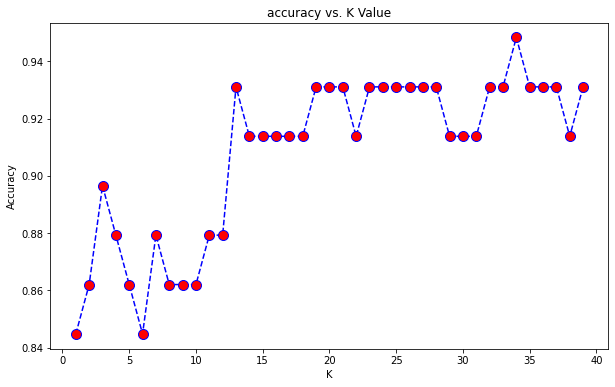

In [47]:
X_train, X_test, y_train, y_test = train_test_data(df, best_features)

acc = []

for i in range(1,40):
    
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # error_rate.append(np.mean(y_pred != y_test))
    acc.append(accuracy_score(y_test, y_pred))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy: ",max(acc),"at K =",acc.index(max(acc)))

In [ ]:
models = [
    ("KNN", KNeighborsClassifier(), 
        {'n_neighbors': [33], 
         'weights': ['uniform', 'distance'],
         'algorithm' : ['auto', 'ball_tree','kd_tree'],
         'p': [1, 2, 3, 4]}),
    
    ("Naive Bayes Bernoulli", BernoulliNB(), 
        {'alpha': [0.1, 1, 10], 
         'fit_prior': [True, False],
         'binarize': [0.0, 0.5, 1.0]}),
    
    ("SVM", SVC(), 
       {'C': [0.1, 1, 10, 100, 1000],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001]})
]

## Tune the parameters

In [ ]:
tuning_results = pd.DataFrame()

# for rank,features in enumerate(best_features):
for name, model, param_grid in models:
    print(f"\ntuning {name} model")
    results = grid_search_model(rank, features, name, model, param_grid, *train_test_data(df, best_features))
    tuning_results = tuning_results.append(results)


tuning KNN model

Now training KNN model
Now tuning KNN model
Fitting 5 folds for each of 168 candidates, totalling 840 fits

tuning Naive Bayes Bernoulli model

Now training Naive Bayes Bernoulli model
Now tuning Naive Bayes Bernoulli model
Fitting 5 folds for each of 18 candidates, totalling 90 fits

tuning SVM model

Now training SVM model
Now tuning SVM model
Fitting 5 folds for each of 100 candidates, totalling 500 fits

tuning KNN model

Now training KNN model
Now tuning KNN model
Fitting 5 folds for each of 168 candidates, totalling 840 fits

tuning Naive Bayes Bernoulli model

Now training Naive Bayes Bernoulli model
Now tuning Naive Bayes Bernoulli model
Fitting 5 folds for each of 18 candidates, totalling 90 fits

tuning SVM model

Now training SVM model
Now tuning SVM model
Fitting 5 folds for each of 100 candidates, totalling 500 fits

tuning KNN model

Now training KNN model
Now tuning KNN model
Fitting 5 folds for each of 168 candidates, totalling 840 fits

tuning Naive 

In [ ]:
tuning_results.sort_values(by='best_accuracy', ascending=False, ignore_index= True ,inplace=True)
tuning_results

,model,features,features ranking,base accuracy,best_accuracy,best_params,precision,recall,confusion_matrix
0,KNN,"[age, ca, cp, oldpeak, restecg, slope, thal]",3,0.879310,0.965517,"KNeighborsClassifier(n_neighbors=13, p=1, weig...",0.967742,0.967742,[[26 1] [ 1 30]]
1,Naive Bayes Bernoulli,"[ca, chol, cp, oldpeak, restecg, sex, slope, t...",1,0.948276,0.948276,BernoulliNB(alpha=0.1),0.966667,0.935484,[[26 1] [ 2 29]]
2,SVM,"[ca, chol, cp, exang, oldpeak, restecg, sex, s...",0,0.965517,0.913793,"SVC(C=1, gamma=0.01)",0.882353,0.967742,[[23 4] [ 1 30]]
3,KNN,"[ca, cp, exang, oldpeak, restecg, sex, slope, ...",2,0.862069,0.913793,"KNeighborsClassifier(n_neighbors=15, p=1)",0.906250,0.935484,[[24 3] [ 2 29]]
4,SVM,"[ca, cp, exang, oldpeak, restecg, sex, slope, ...",2,0.948276,0.913793,"SVC(C=0.1, gamma=0.1)",0.882353,0.967742,[[23 4] [ 1 30]]
5,SVM,"[age, ca, cp, oldpeak, restecg, slope, thal]",3,0.948276,0.913793,"SVC(C=100, gamma=0.01)",0.964286,0.870968,[[26 1] [ 4 27]]
6,Naive Bayes Bernoulli,"[ca, chol, cp, exang, oldpeak, restecg, sex, s...",0,0.896552,0.896552,BernoulliNB(alpha=10),0.931034,0.870968,[[25 2] [ 4 27]]
7,SVM,"[ca, chol, cp, oldpeak, restecg, sex, slope, t...",1,0.965517,0.896552,"SVC(C=1, gamma=1, kernel='linear')",0.931034,0.870968,[[25 2] [ 4 27]]
8,KNN,"[ca, chol, cp, exang, oldpeak, restecg, sex, s...",0,0.862069,0.879310,"KNeighborsClassifier(n_neighbors=7, p=1)",0.875000,0.903226,[[23 4] [ 3 28]]
9,KNN,"[ca, chol, cp, oldpeak, restecg, sex, slope, t...",1,0.879310,0.879310,KNeighborsClassifier(),0.875000,0.903226,[[23 4] [ 3 28]]
